## Q-Learning Example

Reusable Q-Learning class with Cliff walking example

References:
* https://oneraynyday.github.io/ml/2018/09/30/Reinforcement-Learning-TD/
* https://github.com/OneRaynyDay/RLEngine

In [5]:
"""
General purpose finite model baseclass that requires some functions to be implemented.
"""
import numpy as np
from abc import ABCMeta, abstractmethod
from copy import deepcopy

class FiniteModel(object, metaclass=ABCMeta):
    def __init__(self, state_space, action_space, gamma=1.0, epsilon=0.1):
        """FiniteModel takes in state_space and action_space (finite) 
        Arguments
        ---------
        
        state_space: int OR list[observation], where observation is any hashable type from env's obs.
        action_space: int OR list[action], where action is any hashable type from env's actions.
        gamma: float, discounting factor.
        epsilon: float, epsilon-greedy parameter.
        
        If the parameter is an int, then we generate a list, and otherwise we generate a dictionary.
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = None
        if isinstance(action_space, int):
            self.action_space = np.arange(action_space)
            actions = [0]*action_space
            # Action representation
            self._act_rep = "list"
        else:
            self.action_space = action_space
            actions = {k:0 for k in action_space}
            self._act_rep = "dict"
        if isinstance(state_space, int):
            self.state_space = np.arange(state_space)
            self.Q = [deepcopy(actions) for _ in range(state_space)]
        else:
            self.state_space = state_space
            self.Q = {k:deepcopy(actions) for k in state_space}
            
        # Frequency of state/action.
        self.Ql = deepcopy(self.Q)

       
    def pi(self, action, state):
        """pi(a,s,A,V) := pi(a|s)
        We take the argmax_a of Q(s,a).
        q[s] = [q(s,0), q(s,1), ...]
        """
        if self._act_rep == "list":
            if action == np.argmax(self.Q[state]):
                return 1
            return 0
        elif self._act_rep == "dict":
            if action == max(self.Q[state], key=self.Q[state].get):
                return 1
            return 0
    
   
    def b(self, action, state):
        """b(a,s,A) := b(a|s) 
        Sometimes you can only use a subset of the action space
        given the state.
        Randomly selects an action from a uniform distribution.
        """
        return self.epsilon/len(self.action_space) + (1-self.epsilon) * self.pi(action, state)


    def choose_action(self, policy, state):
        """Uses specified policy to select an action randomly given the state.
        Arguments
        ---------
        
        policy: function, can be self.pi, or self.b, or another custom policy.
        state: observation of the environment.
        """
        probs = [policy(a, state) for a in self.action_space]
        return np.random.choice(self.action_space, p=probs)

   
    @abstractmethod
    def score(self, env, policy, n_samples=1000):
        pass


    @abstractmethod
    def update_Q(self, sequence):
        pass

In [6]:
"""
General purpose Q-Learning model for training off-policy methods.
"""
class FiniteQLearningModel(FiniteModel):
    def __init__(self, state_space, action_space, gamma=1.0, epsilon=0.1, alpha=0.01):
        """FiniteQLearningModel takes in state_space and action_space (finite) 
        Arguments
        ---------
        
        state_space: int OR list[observation], where observation is any hashable type from env's obs.
        action_space: int OR list[action], where action is any hashable type from env's actions.
        gamma: float, discounting factor.
        epsilon: float, epsilon-greedy parameter.
        
        If the parameter is an int, then we generate a list, and otherwise we generate a dictionary.
        >>> m = FiniteQLearningModel(2,3,epsilon=0)
        >>> m.Q
        [[0, 0, 0], [0, 0, 0]]
        >>> m.Q[0][1] = 1
        >>> m.Q
        [[0, 1, 0], [0, 0, 0]]
        >>> m.pi(1, 0)
        1
        >>> m.pi(1, 1)
        0
        """
        super(FiniteQLearningModel, self).__init__(state_space, action_space, gamma, epsilon) 
        self.alpha = alpha
       

    def update_Q(self, sars):
        """Performs a TD(0) action-value update using a single step.
        Arguments
        ---------
        
        sars: (state, action, reward, state, action) or (state, action, reward, state), 
            an event in an episode.
        
        NOTE: For Q-Learning, we don't actually use the next action, since we argmax.
        """
        # Generate returns, return ratio
        if len(sars) > 4:
            sars = sars[:4]

        p_state, p_action, reward, n_state = sars
        q = self.Q[p_state][p_action]
        max_q = max(self.Q[n_state].values()) if isinstance(self.Q[n_state], dict) else max(self.Q[n_state])
        self.Q[p_state][p_action] = q + self.alpha * \
            (reward + self.gamma * max_q - q)
   

    def score(self, env, policy, n_samples=1000):
        """Evaluates a specific policy with regards to the env.
        Arguments
        ---------
        
        env: an openai gym env, or anything that follows the api.
        policy: a function, could be self.pi, self.b, etc.
        """
        rewards = []
        for _ in range(n_samples):
            observation = env.reset()
            cum_rewards = 0
            while True:
                action = self.choose_action(policy, observation)
                observation, reward, done, _ = env.step(action)
                cum_rewards += reward
                if done:
                    rewards.append(cum_rewards)
                    break
        return np.mean(rewards)

## Example: Cliff Walking
The change to the code is actually very small because, as I said, Monte Carlo sampling is pretty environment agnostic.

The cliff walking problem is a map where some blocks are cliffs and others are platforms. You get -1 reward for every step on a platform, and -100 reward for every time you fall down the cliff. When you land on a cliff, you go back to the beginning. For how big the map is, -17.0 per episode is a near-optimal policy.

In [7]:
import gym
env = gym.make("CliffWalking-v0")

In [8]:
env.render(mode='rgb_array')

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [9]:
# WARNING: If you try to set eps to a very low value,
# And you attempt to get the m.score() of m.pi, there may not
# be guarranteed convergence.
eps = 3000
S = 4*12
A = 4
START_EPS = 0.7
m = FiniteQLearningModel(S, A, epsilon=START_EPS)

SAVE_FIG = False
history = []

for i in range(1, eps+1):
    ep = []
    prev_observation = env.reset()
    prev_action = m.choose_action(m.b, prev_observation)

    total_reward = 0
    while True:        
        # Run simulation
        next_observation, reward, done, _ = env.step(prev_action)
        next_action = m.choose_action(m.b, next_observation)

        m.update_Q((prev_observation, prev_action, reward, next_observation, next_action))

        prev_observation = next_observation
        prev_action = next_action

        total_reward += reward
        if done:
            break

    history.append(total_reward)


Final expected returns : -13.0


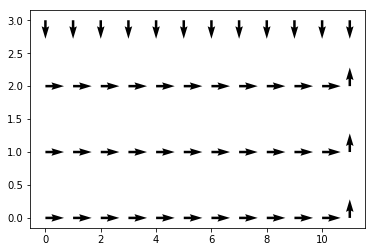

In [10]:
print("Final expected returns : {}".format(m.score(env, m.pi, n_samples=10)))
                              
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

X = 12
Y = 4
Fx = np.zeros((Y, X))
Fy = np.zeros((Y, X))
for y in range(Y):
    for x in range(X):
        amax = np.argmax(m.Q[x+y*12])
        if amax == 0: # UP
            Fy[y, x] = -1
        elif amax == 1: # RIGHT
            Fx[y, x] = 1
        elif amax == 2: # DOWN
            Fy[y, x] = 1
        elif amax == 3: # LEFT
            Fx[y, x] = -1
plt.quiver(Fx,Fy)
plt.show()

Another observation we can see is that Q-learning’s average reward is bad. This is due to the fact that Q-learning tries to take the optimal action, but gets screwed over by the ϵ probability of falling off a cliff due to the stochasticity of the ϵ-greedy policy that it uses to explore.